# Deconvnet
<center>
<img src="https://pbs.twimg.com/media/CDhcrJlWgAAyvWK.png" width="400">
</center>

**Attribution Method**

Researchers present a novel way to map these activities back to
the input pixel space, showing what input pattern originally caused a given activation in the feature maps.




- blog: https://mc.ai/visualizing-and-understanding-convolutional-networks/

- reference: https://github.com/csgwon/pytorch-deconvnet/blob/master/models/vgg16_deconv.py

- transposed convolution: https://github.com/naokishibuya/deep-learning/blob/master/python/transposed_convolution.ipynb

# Import module


In [0]:
# import module
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torch.nn.functional as F
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline  
import random

# Hyperparameters



In [0]:
batch_size = 16
learning_rate = 0.0001
num_epoch = 10

# Data load: MNIST


In [0]:
mnist_train = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                            transforms.RandomCrop(22),
                            transforms.Resize(226),
                            transforms.ToTensor(),
                         ]), 
                         target_transform=None, 
                         download=True)

mnist_test = dset.MNIST("./", train=False,
                        transform=transforms.Compose([
                            transforms.RandomCrop(22),
                            transforms.Resize(226),
                            transforms.ToTensor(),
                        ]),
                        target_transform=None, 
                        download=True)

train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)

# Model: vgg16


We need information about max-pooling value and index of max index. 

```python
torch.nn.MaxPool2d(2, stride=2, return_indices=True)
```

<center/>
<img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16.png" width=500>
</center>





In [0]:
import torchvision.models as models

vgg16_pretrained = models.vgg16(pretrained=True)

class VGG16_conv(torch.nn.Module):
    def __init__(self, n_classes):
        super(VGG16_conv, self).__init__()
        self.features = torch.nn.Sequential(
            # conv1
            torch.nn.Conv2d(3, 64, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv2
            torch.nn.Conv2d(64, 128, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv3
            torch.nn.Conv2d(128, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv4
            torch.nn.Conv2d(256, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv5
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True))
        
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(512*7*7, 4096),  # 224x244 image pooled down to 7x7 from features
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(4096, n_classes))
        
        self._initialize_weights()


    def _initialize_weights(self):
        # initializing weights using ImageNet-trained model from PyTorch
        for i, layer in enumerate(vgg16_pretrained.features):
            if isinstance(layer, torch.nn.Conv2d):
                self.features[i].weight.data = layer.weight.data
                self.features[i].bias.data = layer.bias.data

    def get_conv_layer_indices(self):
        return [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]

    def forward_features(self, x):
        output = x
        for i, layer in enumerate(self.features):
            if isinstance(layer, torch.nn.MaxPool2d):
                output, indices = layer(output)
            else:
                output = layer(output)
        return output

    def forward(self, x):
        output = self.forward_features(x)
        output = output.view(output.size()[0], -1)
        output = self.classifier(output)
        return output

model = VGG16_conv(10)

In [0]:
for layer in model.features:
    layer.requires_grad_(True)


## Train


In [0]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.cuda()
for i in range(num_epoch):
    model.train()
    for j,[image,label] in enumerate(train_loader):
        x = Variable(image)                             
        x = torch.cat([x, x, x], dim=1).type(torch.FloatTensor).cuda()
        y_= Variable(label).cuda()
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
         
    top_1_count = torch.FloatTensor([0])
    total = torch.FloatTensor([0])
    model.eval() 
    for image,label in test_loader:
        x = Variable(image)
        x = torch.cat([x, x, x], dim=1).type(torch.FloatTensor).cuda()
        y_= Variable(label).cuda()

        output = model.forward(x)
        
        values,idx = output.max(dim=1)
        top_1_count += torch.sum(y_==idx).float().cpu().data

        total += label.size(0)

    print("Test Data Accuracy: {}%".format(100*(top_1_count/total).numpy()))
    if (top_1_count/total).numpy() > 0.98:
        break


Test Data Accuracy: [98.82]%


# Deconvnet



In [0]:
from collections import OrderedDict, Sequence
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm

class VGG16_Deconv(nn.Module):
    def __init__(self, model):
        super(VGG16_Deconv, self).__init__()
        self.model = model
        self.fmap_pool = OrderedDict()
        self.pool_indices = OrderedDict()
        self.conv2DeconvIdx = {0:17, 2:16, 5:14, 7:13, 10:11, 12:10, 14:9, 17:7, 19:6, 21:5, 24:3, 26:2, 28:1}
        self.conv2DeconvBiasIdx = {0:16, 2:14, 5:13, 7:11, 10:10, 12:9, 14:7, 17:6, 19:5, 21:3, 24:2, 26:1, 28:0}
        self.unpool2PoolIdx = {15:4, 12:9, 8:16, 4:23, 0:30}
        self.feature2Deconv = {0:17, 1:16, 2:14, 3:13, 4:11, 5:10, 6:9, 7:7, 8:6, 9:5, 10:3, 11:2, 12:1}
        self.idx2Pool = {}

        def forward_hook_conv(module, input, output):
            if isinstance(module, nn.Conv2d):
                self.fmap_pool[module] = output.detach()

        def forward_hook_pool(module, input, output):
            if isinstance(module, nn.MaxPool2d):
                self.pool_indices[module] = [output[1], input[0].size()]
        
        for layer in self.model.features:
            if isinstance(layer, nn.Conv2d):
                layer.register_forward_hook(forward_hook_conv)
            if isinstance(layer, nn.MaxPool2d):
                layer.register_forward_hook(forward_hook_pool)
   
        self.deconv_info = self._get_deconv_info(model)
        self.deconv_layer, self.deconv_one_channel = self._make_deconv_layer(self.deconv_info)
        self._set_weight()

    def _get_deconv_info(self, model):
        info = []
        for layer in model.features:
            if isinstance(layer, nn.Conv2d):
                info.append(["Conv2d", layer.in_channels, layer.out_channels, layer.kernel_size, layer.stride])
            if isinstance(layer, nn.MaxPool2d):
                info.append(['Maxpool2d', layer, None, layer.kernel_size, layer.stride])
        return info[::-1]

    def _make_deconv_layer(self, info):
        layers, layers_one = [], []
        for i, (module, ic, oc, k, s) in enumerate(info):
            if module == 'Conv2d':
                layers.append(nn.ConvTranspose2d(oc, ic, k, padding=1))
                layers_one.append(nn.ConvTranspose2d(1, ic, k, padding=1))
            if module == 'Maxpool2d':
                self.idx2Pool[i] = ic
                layers.append(nn.MaxUnpool2d(k, stride=s))
                layers_one.append(nn.MaxUnpool2d(k, stride=s))
    
        return nn.Sequential(*layers), nn.Sequential(*layers_one)


    def _set_weight(self):
        '''
        Because of structure of deconvolution, 
        Note that bias i-th layer in deconvolution layer is bias j-th layer in model.features. 
        '''
        for i, layer in enumerate(self.model.features):
            if isinstance(layer, nn.Conv2d):
                if self.deconv_layer[self.conv2DeconvIdx[i]].weight.shape != layer.weight.shape:
                    raise ValueError('Unvalid weight shape {} != {}'.format(self.deconv_layer[self.conv2DeconvIdx[i]].weight.shape,
                                                                            layer.weight.shape))
                self.deconv_layer[self.conv2DeconvIdx[i]].weight.data = layer.weight.data
                bias_idx = self.conv2DeconvBiasIdx[i]
                if bias_idx > 0:
                    if self.deconv_layer[bias_idx].bias.shape != layer.bias.shape:
                        raise ValueError('Unvalid Bias shape {} != {}'.format(self.deconv_layer[bias_idx].bias.shape,
                                                                                layer.bias.shape))
                    self.deconv_layer[bias_idx].bias.data = layer.bias.data
                

    def forward(self, x):
        return model.forward(x)

    def deconv(self, act_number, map_number):
        '''Return deconvolution
        act_number: Index for activation map(VGG16.fmap_pool), Int.
        layer_number: Layer index, Int.
        map_number: Filter index, Int.
        pool_indices:

        Return
            output: deconvolution result
        '''
        if self.feature2Deconv.get(act_number, -1) == -1:
            raise ValueError("Impossible actnumber {}! Choose 1 ~ 12".format(act_number)) 
        key = list(self.fmap_pool.keys())[act_number]
        start_idx = self.feature2Deconv[act_number]

        if isinstance(key, nn.Conv2d):
            x = torch.unsqueeze(self.fmap_pool[key][:, 0, :, :], dim=0) # activation map: forward-hook
        else:
            raise ValueError("Unvalid layer {}".format(key))
        
        if self.deconv_one_channel[start_idx].weight.shape != self.deconv_layer[start_idx].weight[map_number][None, :, :, :].shape:
            raise ValueError("Weight shape one_channel {} != total {}".format(self.deconv_one_channel[start_idx].weight.shape,
                                                                              self.deconv_layer[start_idx].weight[map_number][None, :, :, :].shape))
        
        if self.deconv_one_channel[start_idx].bias.shape != self.deconv_layer[start_idx].bias.shape:
            raise ValueError("Bias shape one_channel {} != total {}".format(self.deconv_one_channel[start_idx].bias.shape,
                                                                              self.deconv_layer[start_idx].bias.shape))
            
        self.deconv_one_channel[start_idx].weight.data = self.deconv_layer[start_idx].weight[map_number][None, :, :, :].data
        self.deconv_one_channel[start_idx].bias.data = self.deconv_layer[start_idx].bias.data
        output = self.deconv_one_channel[start_idx](x)
        for i, layer in enumerate(self.deconv_layer[start_idx + 1:]):
            if isinstance(layer, nn.ConvTranspose2d):
                output = layer(output)

            if isinstance(layer, nn.MaxUnpool2d):
                k = self.idx2Pool[start_idx + 1 + i]
                output = layer(output, self.pool_indices[k][0], output_size=self.pool_indices[k][1])
        return output 




## Test code


In [0]:
import unittest


class DeconvTests(unittest.TestCase):
    
    def setUp(self):
        '''Before run test, set up!'''
        self.vgg16 = VGG16_Deconv(model)
        self.vgg16.deconv_layer.cuda()
        self.input_tensor = torch.zeros(1, 3, 226, 226).cuda()
        self.info = []

    def test_runs(self):
        self.vgg16.forward(self.input_tensor)
        print('OK, vgg16 forward working well!')

    def test_get_deconv_info(self):
        self.assertEqual(len(self.vgg16._get_deconv_info(model)), 18)
        print('OK,Same length!')

    def test_deconv(self):
        self.assertEqual(self.vgg16.deconv(0, 10).size()[1], 3)
        print('OK,Deconvolution channel is 3')
    


test = DeconvTests()
test.setUp()
test.test_runs()
test.test_get_deconv_info()
test.test_deconv()

OK, vgg16 forward working well!
OK,Same length!
output:  torch.Size([1, 3, 226, 226])
start_idx:  17
OK,Deconvolution channel is 3


## Visualization



In [0]:
# make image tensor
for images, labels in train_loader:
    image, label = images[0], labels[0]
    break
input_image = image
image = torch.cat([image, image, image], dim=0)
image = torch.unsqueeze(image, dim=0)

In [0]:
# forwarding test
model.cuda()
vgg16 = VGG16_Deconv(model)
vgg16.deconv_layer.cuda()
vgg16.deconv_one_channel.cuda()
vgg16.forward(image.cuda())

tensor([[-2.5251, -1.2768, -1.3723, -5.6887, -2.5213, -0.5494, 14.9243, -8.2531,
         -1.7843, -5.5693]], device='cuda:0', grad_fn=<AddmmBackward>)

In [0]:
deconv = vgg16.deconv(10, 0)


output:  torch.Size([1, 512, 14, 14])
start_idx:  3


In [0]:
deconv = deconv.detach().cpu().numpy()
deconv = np.squeeze(deconv)
# deconv = np.transpose(deconv, (1, 2, 0))

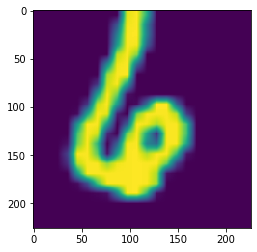

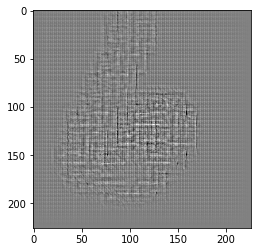

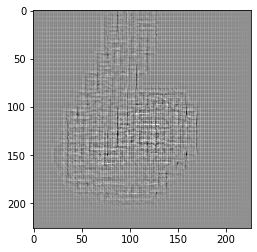

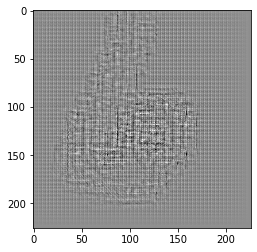

In [0]:
plt.imshow(input_image[0])
plt.show()

for i in range(len(deconv)):
    plt.imshow(deconv[i], cmap=plt.cm.gray)
    plt.show()